# Training Pipeline

From the first notebook for data collection, we have collected different datasets with different approaches. Now it's time to train our models with collected datasets. In this notebook we will go through the training process of different models. The training process is generally divided into four steps, data preparation, building the model, training the model and test inference.

**HINTS:**

Before running all the following cells for training, please place **the folder ‘model’ as well as this notebook Training_Pipeling.ipynb** under path <code>/storage/remote/atcremers51/truck_platooning</code>. 

Then we can start the training process in following cells. 

**The models to be trained and their corresponding datasets are listed as follows,**
1. MLP(Multi-layer Perceptron) model trained with raw states
2. MLP model trained with relative transformation
3. FCNN(Fully Connected Neural Network) model trained end-to-end with CARLA online dataset
4. Two-step CNN(Convolutional Neural Network)-MLP model trained with CARLA online dataset
5. Two-step CNN-MLP model trained with depth-based dataset
6. Two-step CNN-MLP model trained with stereo-based dataset
 


## 1. Data Preparation

### Import packages

In [3]:
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader 
import random
import time
import torchvision.transforms as transforms

%load_ext autoreload
%autoreload 2

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


<div class="alert alert-warning">
    <h3>Note: Google Colab</h3>
    <p>
In case you don't have a GPU, you can run this notebook on Google Colab where you can access a GPU for free, but, of course, you can also run this notebook on your CPU.
         </p>
</div>

### Import datasets for different models
Here we used <code>torch.utils.data.Dataset</code> to build custom datasets. All Dataset classes are stored in <code>model/my_datasets.py</code>. The following cells corresponds to the **dataset preparation processes of different models**. If you want to import the dataset for one of the models mentioned above, please run the corresponding cell.

All datasets used for training are stored on the remote machine under <code>/storage/remote/atcremers51/turck_platooning/dataset</code>. 

In [ ]:
import sys
sys.path.insert(0,'/storage/remote/atcremers51/truck_platooning/')

#### 1) MLP with raw states
Here we used the dataset collected directly in CARLA simulator(https://carla.org/) with around 30,000 samples from only one trajectory in town04. The MLP model trained with raw states has 8 inputs (x_ref, y_ref, yaw_ref, v_ref, x_ego, y_ego, yaw_ego, v_ego) and 2 outputs (throttle, steering angle). 

In [29]:
from model.my_datasets import MyDataset_MLP 
from dataset.MLP_raw_dataset.model_input_all import state_on, input_0, input_4, input_5, input_6
from dataset.MLP_raw_dataset.model_gt_all import label_on,label_0, label_4, label_5, label_6

# gather all data together
input_all = np.concatenate((state_on, input_0, input_4, input_5, input_6), axis = 0) 
label_all = np.concatenate((label_on,label_0, label_4, label_5, label_6), axis = 0) 
data_all = np.concatenate((input_all, label_all), axis = 1) 
np.random.shuffle(data_all)
print('Number of all samples:', data_all.shape[0])

Number of all samples: 30800


In [26]:
# split into train dataset, validation dataset, and test dataset
def split_dataset(data, split_list):
    split_num = data.shape[0] * np.array(split_list)
    return data[:round(split_num[0]), :], data[round(split_num[0]):round(split_num[1]+split_num[0]), :], data[round(split_num[1]+split_num[0]):, :]

split_list = [0.7, 0.2, 0.1]
train_input, val_input, test_input = split_dataset(data_all[:, :8], split_list)
train_label, val_label, test_label = split_dataset(data_all[:, 8:], split_list)  

In [27]:
# over_data with only two samples to test if the model can overfit at the beginning. 
over_input = data_all[:2, :8]
over_label = data_all[:2, 8:]

train_data = MyDataset_MLP(states = train_input, labels = train_label)
val_data = MyDataset_MLP(states = val_input, labels = val_label)
test_data = MyDataset_MLP(states = test_input, labels = test_label)
over_data = MyDataset_MLP(states = over_input, labels = over_label)   

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=True)
over_loader = DataLoader(dataset=over_data, batch_size=2, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Test size: %i" % len(test_data))
print("Input: [x_ref, y_ref, yaw_ref, v_ref, x_ego, y_ego, yaw_ego, v_ego]")
print('Input Example:', train_data[0][0])
print("Label: [throttle, steering angle]")
print('Label Example:', train_data[0][1])

Train size: 21560
Validation size: 6160
Test size: 3080
Input: [x_ref, y_ref, yaw_ref, v_ref, x_ego, y_ego, yaw_ego, v_ego]
Input Example: [ -91.7649231  -173.44224548    2.35847948   11.34753924  -82.95633698
 -181.47247314    2.45331891   11.71396709]
Label: [throttle, steering angle]
Label Example: [ 0.31716372 -0.02316087]


#### 2) MLP with relative states
Here we used the dataset collected directly in CARLA simulator with around 60,000 samples from two trajectories in town04. The MLP model trained with raw states has 5 inputs (delta_x, delta_y, delta_yaw, v_ref, v_ego) and 2 outputs (throttle, steering angle). 

In [31]:
from dataset.carla_online_dataset.data_transform_array import data_transform 
from model.my_datasets import MyDataset_MLP 

In [32]:
# split into train dataset, validation dataset, and test dataset
def split_dataset(data, split_list): 
    split_num = data.shape[0] * np.array(split_list) 
    return data[:round(split_num[0]), :], data[round(split_num[0]):round(split_num[1]+split_num[0]), :], data[round(split_num[1]+split_num[0]):, :]
 
np.random.shuffle(data_transform) 
split_list = [0.8, 0.1, 0.1]
train_input, val_input, test_input = split_dataset(data_transform[:, :5], split_list)
train_label, val_label, test_label = split_dataset(data_transform[:, 5:], split_list) 
print('Number of all samples:', data_transform.shape[0])

Number of all samples: 63088


In [33]:
# over_data with only two samples to test if the model can overfit at the beginning. 
over_input = data_transform[:2, :5]
over_label = data_transform[:2, 5:]

train_data = MyDataset_MLP(states = train_input, labels = train_label)
val_data = MyDataset_MLP(states = val_input, labels = val_label)
test_data = MyDataset_MLP(states = test_input, labels = test_label)
over_data = MyDataset_MLP(states = over_input, labels = over_label)   

train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=128, shuffle=True)
over_loader = DataLoader(dataset=over_data, batch_size=2, shuffle=True)

print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Test size: %i" % len(test_data)) 
print('Input: [delta_x, delta_y, delta_yaw, v_ref, v_ego]')
print('Input Example:', train_data[0][0])
print('Label: [throttle, steering angle]')
print('Label Example:', train_data[0][1]) 


Train size: 50470
Validation size: 6309
Test size: 6309
Input: [delta_x, delta_y, delta_yaw, v_ref, v_ego]
Input Example: [ 7.85743061 -0.01319448 -0.0681724   1.72255247  3.43581793]
Label: [throttle, steering angle]
Label Example: [1.         0.02989528]


#### 3) End-to-end FCNN
Here we used the dataset collected directly in CARLA simulator with around 60,000 samples from two trajectories in town04. The FCNN model has 3 inputs (RGB image, v_ref, v_ego) and 2 outputs (throttle, steering angle).  

In [34]:
from model.my_datasets import MyDataset_FCNN 

In [36]:
# split into train dataset, validation dataset, and test dataset 
# over_data with only 4 samples to test if the model can overfit at the beginning.
ROOT = './dataset/carla_online_dataset/' 
train_out = open(ROOT+"traindata_shuffle_fcnn.txt",'w')
val_out = open(ROOT+"valdata_shuffle_fcnn.txt",'w')
over_out = open(ROOT+"overdata_shuffle_fcnn.txt",'w')
lines=[]
with open(ROOT+"data_all.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count< 4:
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()

In [38]:
INPUT_SIZE = (128,128)
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


over_data = MyDataset_CNN(root = ROOT, txtname = 'overdata_shuffle_fcnn.txt', transform=TRANSFORM, size=INPUT_SIZE)
train_data = MyDataset_CNN(root = ROOT, txtname = 'traindata_shuffle_fcnn.txt' , transform = TRANSFORM, size= INPUT_SIZE)
val_data = MyDataset_CNN(root = ROOT, txtname = 'valdata_shuffle_fcnn.txt', transform = TRANSFORM, size= INPUT_SIZE)

over_loader = DataLoader(dataset=over_data, batch_size=4, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4) 


print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Overfit size: %i" % len(over_data))

Train size: 50472
Validation size: 12616
Overfit size: 4


#### 4) CNN-MLP model trained with CARLA online dataset
Here we used the dataset collected directly in CARLA simulator with around 60,000 samples from two trajectories in town04. 

The MLP model is trained before in section 3. Here our goal is to train a CNN to predict relative transformation. The CNN has 3 inputs (RGB image, v_ref, v_ego) and 3 outputs (delta_x, delta_y, delta_yaw).  

In [49]:
from model.my_datasets import MyDataset_CNN

In [50]:
# split into train dataset, validation dataset, and test dataset 
# over_data with only 4 samples to test if the model can overfit at the beginning.
ROOT = './dataset/carla_online_dataset/'  
train_out = open(ROOT+"traindata_shuffle_cnn.txt",'w')
val_out = open(ROOT+"valdata_shuffle_cnn.txt",'w')
over_out = open(ROOT+"overdata_shuffle_cnn.txt",'w')
lines=[]
with open(ROOT+"data_transformation.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count< 4:
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()    

In [51]:
INPUT_SIZE = (128,128)
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


over_data = MyDataset_CNN(root = ROOT, txtname = 'overdata_shuffle_cnn.txt', transform=TRANSFORM, size=INPUT_SIZE)
train_data = MyDataset_CNN(root = ROOT, txtname = 'traindata_shuffle_cnn.txt' , transform = TRANSFORM, size= INPUT_SIZE)
val_data = MyDataset_CNN(root = ROOT, txtname = 'valdata_shuffle_cnn.txt', transform = TRANSFORM, size= INPUT_SIZE)

over_loader = DataLoader(dataset=over_data, batch_size=4, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4) 


print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Overfit size: %i" % len(over_data))


Train size: 50472
Validation size: 12616
Overfit size: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image size: torch.Size([3, 128, 128])
Input v_ref and v_ego: 5.140 m/s, 5.031 m/s
Labels (delta_x, delta_y, delta_yaw): [ 6.72283316 -1.82382181 -0.30510984]


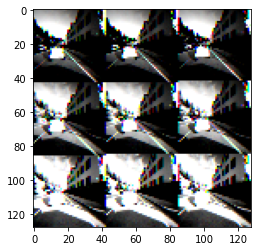

In [62]:
print('Input image size:',over_data[0][0][0].shape)
print('Input v_ref and v_ego: %.3f m/s, %.3f m/s' %(over_data[0][0][1], over_data[0][0][2]))
print('Labels (delta_x, delta_y, delta_yaw):', over_data[0][1])
plt.imshow(over_data[0][0][0].view(128,128,3))

#### 5) CNN-MLP model trained with depth-based dataset
Here we used the dataset collected through image rendering. It contains around 45,000 samples. The on-trajectory data is directly collected from CARLA simulator. And the off-trajectory data is generated with **the depth map taken by depth camera in CARLA simulator**. 

The MLP model is trained before in section 3. Here our goal is to train a CNN to predict relative transformation. The CNN has 3 inputs (RGB image, v_ref, v_ego) and 3 outputs (delta_x, delta_y, delta_yaw).  

In [63]:
from model.my_datasets import MyDataset_CNN

In [73]:
# split into train dataset, validation dataset, and test dataset 
# over_data with only 4 samples to test if the model can overfit at the beginning. 
ROOT = './dataset/depth_dataset/' 
train_out = open(ROOT+"traindata_shuffle_depth.txt",'w')
val_out = open(ROOT+"valdata_shuffle_depth.txt",'w')
over_out = open(ROOT+"overdata_shuffle_depth.txt",'w')
lines=[]
with open(ROOT+"delta_data.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count< 4:
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()   

In [74]:
INPUT_SIZE = (128,128)
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


over_data = MyDataset_CNN(root = ROOT, txtname = 'overdata_shuffle_depth.txt', transform=TRANSFORM, size=INPUT_SIZE)
train_data = MyDataset_CNN(root = ROOT, txtname = 'traindata_shuffle_depth.txt' , transform = TRANSFORM, size= INPUT_SIZE)
val_data = MyDataset_CNN(root = ROOT, txtname = 'valdata_shuffle_depth.txt', transform = TRANSFORM, size= INPUT_SIZE)

over_loader = DataLoader(dataset=over_data, batch_size=4, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4) 


print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Overfit size: %i" % len(over_data))

Train size: 36401
Validation size: 9099
Overfit size: 4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Input image size: torch.Size([3, 128, 128])
Input v_ref and v_ego: 9.829 m/s, 9.704 m/s
Labels (delta_x, delta_y, delta_yaw): [ 1.01969358e+01 -1.49289740e+00 -9.52785141e-03]


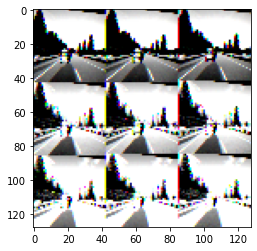

In [75]:
print('Input image size:',over_data[0][0][0].shape)
print('Input v_ref and v_ego: %.3f m/s, %.3f m/s' %(over_data[0][0][1], over_data[0][0][2]))
print('Labels (delta_x, delta_y, delta_yaw):', over_data[0][1])
plt.imshow(over_data[0][0][0].view(128,128,3))

#### 6) CNN-MLP model trained with stereo-based dataset
Here we used the dataset collected through image rendering. It contains around 40,000 samples. The on-trajectory data is directly collected from CARLA simulator. And the off-trajectory data is generated with **estimated depth map based on stereo vision system**. 

The MLP model is trained before in section 3. Here our goal is to train a CNN to predict relative transformation. The CNN has 3 inputs (RGB image, v_ref, v_ego) and 3 outputs (delta_x, delta_y, delta_yaw).  

In [ ]:
from model.my_datasets import MyDataset_CNN

In [ ]:
# split into train dataset, validation dataset, and test dataset 
# over_data with only 4 samples to test if the model can overfit at the beginning.
ROOT = './dataset/stereo_dataset/'  
train_out = open(ROOT+"traindata_shuffle_stereo.txt",'w')
val_out = open(ROOT+"valdata_shuffle_stereo.txt",'w')
over_out = open(ROOT+"overdata_shuffle_stereo.txt",'w')
lines=[]
with open(ROOT+"delta_data.txt", 'r') as infile:
    for line in infile:
        lines.append(line)
    random.shuffle(lines)
    num_train = np.ceil(0.8*len(lines))
    for count, line in enumerate(lines):
        if count <=num_train:
            if count< 4:
                over_out.write(line)
            train_out.write(line)
        else:
            val_out.write(line) 
train_out.close()            
val_out.close()
over_out.close()   

In [ ]:
INPUT_SIZE = (128,128)
TRANSFORM = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]) 


over_data = MyDataset_CNN(root = ROOT, txtname = 'overdata_shuffle_depth.txt', transform=TRANSFORM, size=INPUT_SIZE)
train_data = MyDataset_CNN(root = ROOT, txtname = 'traindata_shuffle_depth.txt' , transform = TRANSFORM, size= INPUT_SIZE)
val_data = MyDataset_CNN(root = ROOT, txtname = 'valdata_shuffle_depth.txt', transform = TRANSFORM, size= INPUT_SIZE)

over_loader = DataLoader(dataset=over_data, batch_size=4, shuffle=True)
train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4)
val_loader = DataLoader(dataset=val_data, batch_size=256, shuffle=True, pin_memory=True, num_workers = 4) 


print("Train size: %i" % len(train_data))
print("Validation size: %i" % len(val_data))
print("Overfit size: %i" % len(over_data))

In [ ]:
print('Input image size:',over_data[0][0][0].shape)
print('Input v_ref and v_ego: %.3f m/s, %.3f m/s' %(over_data[0][0][1], over_data[0][0][2]))
print('Labels (delta_x, delta_y, delta_yaw):', over_data[0][1])
plt.imshow(over_data[0][0][0].view(128,128,3))

## 2. Build the model
To train different models, we first define different model architectures inherited from <code>torch.nn.Module</code> in <code>model/my_models.py</code>. The following cells show **the process of model imports and model building**. If you want to define one of the models mentioned above, please run the corresponding cell.  

### 1) MLP with raw states

In [ ]:
from model.my_models import MyModel_MLP_raw
neurons = [256, 1024, 2048, 1024, 256]
mynet = MyModel_MLP_raw(neurons)
mynet.to(device)
print(mynet)

### 2) MLP with relative states

In [ ]:
from model.my_models import MyModel_MLP_transform
neurons = [256, 1024, 256]
mynet = MyModel_MLP_transform(neurons)
mynet.to(device)
print(mynet)

### 3)  End-to-end FCNN

In [ ]:
from model.my_models import MyModel_FCNN_endtoend
mynet = MyModel_FCNN_endtoend()
mynet.to(device)
print(mynet)

### 4) 5) 6)  CNN-MLP
The three CNN-MLP models trained with different datasets have the same architecture. 

In [ ]:
from model.my_models import MyModel_CNN_relative
mynet = MyModel_CNN_relative()
mynet.to(device)
print(mynet)

### Check the number of trainable parameters 

In [ ]:
total_params = sum(p.numel() for p in mynet.parameters())
print(f'{total_params:,} total parameters.')
total_trainable_params = sum(
    p.numel() for p in mynet.parameters() if p.requires_grad)
print(f'{total_trainable_params:,} trainable parameters.')

## 3. Train the model

### Define the loss function and optimizer

In [ ]:
mycriterion = nn.MSELoss(reduction='mean') 
myoptimizer = optim.Adam(mynet.parameters(), lr=1e-4, eps = 1e-08) 

### Start training
  

#### 1）2）MLP with raw states / relative states

To start training, we should first use a small dataset(over_data) to test if our model can overfit with such small dataset. If so, our model is reasonable and we can start training. Then we can start to train the model. After training for hundreds of epochs, the trained model will be saved. At last, we test the model inference with 50 samples in test dataset to see how well the model has been trained and how large the difference between the prediction and ground truth.

In [ ]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0  
     
    for i, data in enumerate(dataloader, 0): 
        X, y = data
        X = X.to(device)
        y = y.to(device) 
        if iftrain:   
            optimizer.zero_grad()
            y_pred = model(X.to(torch.float32)) 
            y_pred = y_pred.float()
            y = y.float() 
            
            loss = criterion(y_pred, y)  
            loss.backward()             
            optimizer.step()            
            running_loss += loss.item() 
        else:
            model.eval()
            y_pred = model(X.to(torch.float32))
            y_pred = y_pred.float()  
            y = y.float() 
            loss = criterion(y_pred , y)  
            running_loss += loss.item()    
    return running_loss

In [ ]:
# test if the model will overfit with small dataset
max_epochs = 1000 
train_history = []
val_history = []

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss, val_loss))

In [ ]:
# start the main training process
max_epochs = 1000
num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

print('Start training!')

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    if epoch % 100 == 99:
      print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
          (train_loss/num_trainbatch, val_loss/num_valbatch)) 
print('Finish training!')

In [ ]:
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
# save the best model
torch.save(best_model.state_dict(),'./model/best_model_MLP.pth')
print('MLP Model saved！')

In [ ]:
# test inference 
for n, data in enumerate(test_loader): 
        X = torch.tensor(data[0]).to(device) 
        y = torch.tensor(data[1]).to(device)
        if n < 50:
            for i, x in enumerate(X): 
            mynet.eval()
            x = x[None, :]
            y_pred = mynet(x.to(torch.float32))  
            print('prediction  : {},\nground truth：{}'.format(y_pred, y[i])) 

#### 3) End-to-end FCNN

To start training, we should first use a small dataset(over_data) to test if our model can overfit with such small dataset. If so, our model is reasonable and we can start training. Then we can start to train the model. After training for hundreds of epochs, the trained model will be saved. At last, we test the model inference with 50 samples in test dataset to see how well the model has been trained and how large the difference between the prediction and ground truth.  

In [ ]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0   
    
    for i, data in enumerate(dataloader, 0): 
        X, y = data 
        X = [x.to(device) for x in X] 
        y = y.to(device) 
        
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X) 
            y_pred = y_pred.float() 
            y = y.float() 
            loss = criterion(y_pred, y) 
            loss.backward()             
            optimizer.step()
            running_loss += loss.item()              
            
        else:
            y_pred = model(X)
            y_pred = y_pred.float()  
            y = y.float() 
            loss = criterion(y_pred, y)  
            running_loss += loss.item()      
    return running_loss

In [ ]:
# test if the model will overfit with small dataset
max_epochs = 1000 
train_history = []
val_history = []

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    if epoch % 100 == 99:
        print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %2e, val_loss: %2e "% 
          (train_loss, val_loss))

In [ ]:
# start the main training process
max_epochs = 500
num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []

print('Start training!')

for epoch in range(max_epochs): 
    train_loss = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss/num_trainbatch)
    val_loss =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss/num_valbatch)
    if epoch % 100 == 99:
      print(f"Epoch {epoch + 1: >3}/{max_epochs}, train_loss: %e, val_loss: %e "% 
          (train_loss/num_trainbatch, val_loss/num_valbatch)) 
print('Finish training!')

In [ ]:
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
# save the best model
torch.save(best_model.state_dict(),'./model/best_model_FCNN.pth')
print('FCNN Model saved！')

In [ ]:
# test inference
for i in range(50):
    test_num = random.randint (0, 100)
    test_in, gt_output = val_data[test_num]
    test_in = [torch.tensor(x).to(device) for x in test_in] 
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

####  4) 5) 6)  CNN-MLP
The three CNN-MLP models trained with different datasets have the same training process. The three outputs(delta_x, delta_y, delta_yaw) have different scales. delta_y and delta_yaw always have extremely small values. Thus, to obtain a gooe training result, it's necessary to **observe the loss of these three outputs separately.**

To start training, we should first use a small dataset(over_data) to test if our model can overfit with such small dataset. If so, our model is reasonable and we can start training. Then we can start to train the model. In order to avoid overfitting, we used the **early stop strategy**. If the validation loss doesn't fall in 10 epochs, the training process will be stopped. And the trained model with the lowest validation loss will be saved as the best model. At last, we test the model inference with 50 samples in test dataset to see how well the model has been trained and how large the difference between the prediction and ground truth.  

In [ ]:
def run_epoch(model,criterion,optimizer,dataloader,iftrain):    
    running_loss = 0.0 
    running_loss0 = 0.0
    running_loss1 = 0.0
    running_loss2 = 0.0 
    
    for i, data in enumerate(dataloader, 0): 
        X, y = data 
        X = [x.to(device) for x in X] 
        y = y.to(device) 
        
        if iftrain:  
            optimizer.zero_grad()
            y_pred = model(X) 
            y_pred = y_pred.float() 
            y = y.float() 
            loss0 = criterion(y_pred[:,0], y[:,0])
            loss1 = criterion(y_pred[:,1], y[:,1])
            loss2 = criterion(y_pred[:,2], y[:,2]) 
            loss = (loss0 + loss1 + loss2)/3   
            loss.backward()             
            optimizer.step()
            running_loss += loss.item()
            running_loss0 += loss0.item() 
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()             
            
        else:
            y_pred = model(X)
            y_pred = y_pred.float()  
            y = y.float() 
            loss0 = criterion(y_pred[:,0], y[:,0])
            loss1 = criterion(y_pred[:,1], y[:,1])
            loss2 = criterion(y_pred[:,2], y[:,2])  
            loss = (loss0 + loss1 + loss2)/3

            running_loss += loss.item()
            running_loss0 += loss0.item() 
            running_loss1 += loss1.item()
            running_loss2 += loss2.item()      
    return running_loss, running_loss0, running_loss1, running_loss2  

In [ ]:
# test if the model will overfit with small dataset
max_epochs = 1000
train_history = []
val_history = []  
for epoch in range(max_epochs): 
    start = time.time()
    train_loss,_,_,_ = run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss, val_loss0, val_loss1, val_loss2 =  run_epoch(model=mynet,criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=over_loader,
                           iftrain=False)
    val_history.append(val_loss)
    end = time.time()
    if epoch % 50 == 49:
        print('Epoch %.0f / 1000, train_loss: %2e, val_loss: %2e(%2e,%2e,%2e), runtime:% s' % 
              (epoch+1, train_loss, val_loss, val_loss0, val_loss1, val_loss2, end-start))        

In [ ]:
# start the main training process
num_trainbatch = np.ceil(len(train_data)/256) 
num_valbatch = np.ceil(len(val_data)/256) 
train_history = []
val_history = []
min_loss = 100000
current_patience = 0
patience = 10
best_model = MyModel_CNN_relative()
best_model.to(device)
max_epochs = 100

print('Start training!')
for epoch in range(max_epochs): 
    start = time.time()
    train_loss,_,_,_ = run_epoch(model=mynet, criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=train_loader,
                           iftrain=True)
    train_history.append(train_loss)
    val_loss, val_loss0, val_loss1, val_loss2 =  run_epoch(model=mynet, criterion=mycriterion,
                           optimizer=myoptimizer,dataloader=val_loader,
                           iftrain=False)
    val_history.append(val_loss)
    end = time.time()
    if epoch % 10 == 9:
    print('Epoch %.0f / %.0f, train_loss: %2e, val_loss: %2e(%2e,%2e,%2e), runtime:% s' % 
              (epoch+1, max_epochs, train_loss/num_trainbatch, val_loss/num_valbatch, val_loss0/num_valbatch, val_loss1/num_valbatch, val_loss2/num_valbatch, end-start))


    # early stopping
    if min_loss == 100000 or val_loss < min_loss :
        min_loss = val_loss
        current_patience = 0
        best_model = mynet 
      
    else :
        current_patience += 1 
        if current_patience >= patience :
            print("Stopping early at epoch {}!".format(epoch+1)) 
            break   

print('Finish training!')

In [ ]:
# plot the train & validation loss curve with small dataset
epochs = range(len(train_history))
plt.figure()
plt.plot(epochs, train_history, 'bo', label='Training loss')
plt.plot(epochs, val_history, 'b', label='Validation loss')
plt.title('Training and validation loss')

plt.legend()
plt.show()

In [ ]:
# save the best model
torch.save(best_model.state_dict(),'./model/best_model_CNN.pth')
print('Model saved！')

In [ ]:
# test inference
for i in range(50):
    test_num = random.randint (0, 100)
    test_in, gt_output = val_data[test_num]
    test_in = [torch.tensor(x).to(device) for x in test_in] 
    gt_output = torch.tensor(gt_output).to(device)
    output_pred = mynet(test_in) 
    print('prediction:{}, ground truth:{}'.format(output_pred.cpu().detach().numpy(), gt_output.cpu().detach().numpy()))

# Summary

In this notebook, we go through the entire training process of 6 different models with different dataseets. After training the models, the next step will be to use these models to do inference in the unseen test trajectories in CARLA.